In [1]:
!apt-get update && apt-get install -y wget ffmpeg libsm6 libxext6 && apt-get clean
!pip install opencv-python scipy
!./download_dataset.sh
!python generate_labels.py

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease          
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease        
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the newest version (2:1.2.2-1).
libxext6 is already the newest version (2:1.3.3-1).
wget is already the newest version (1.19.4-1ubuntu2.2).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).

In [2]:
import os
from glob import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Activation, \
                                    MaxPool2D, Input, UpSampling2D, concatenate, Input, \
                                    RandomFlip, RandomRotation, RandomZoom

In [3]:
def load_train_pairs():
    filenames = set([os.path.basename(file) for file in glob('dataset/unlabeled/*.png')] +
                    [os.path.basename(file) for file in glob('dataset/labeled/*.png')])
    unlabeled_paths = [os.path.join('dataset/unlabeled', file) for file in filenames]
    labeled_paths = [os.path.join('dataset/labeled', file) for file in filenames]
    train_pairs = [(u, l) for u, l in zip(unlabeled_paths, labeled_paths)
                   if os.path.exists(u) and os.path.exists(l)]
    # TODO: add filter to ensure the image width and height is >= 256
    return train_pairs


def normalize(imgpath, maskpath, outshape=(256, 256)):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    img = cv2.filter2D(img, -1, kernel)
    img = cv2.resize(img, outshape) / 255

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask = cv2.resize(mask, outshape)
    tmpmask = cv2.imread(maskpath, 0)
    tmpmask = cv2.resize(tmpmask, outshape)
    mask = cv2.bitwise_or(mask, tmpmask)
    mask = np.expand_dims(mask, -1) / 255
    return img, mask


def create_dataset(path_pairs):
    img_batch = []
    mask_batch = []
    for imgpath, maskpath in path_pairs:
        img, mask = normalize(imgpath, maskpath)
        img_batch.append(img)
        mask_batch.append(mask)
    return np.array(img_batch), np.array(mask_batch)


In [4]:
def upsample(input, input_size):
    up = Conv2D(input_size, (3, 3), padding='same')(input)
    up = BatchNormalization()(up)
    up = Activation('relu')(up)
    up = Conv2D(input_size, (3, 3), padding='same')(up)
    up = BatchNormalization()(up)
    up = Activation('relu')(up)
    up = Conv2D(input_size, (3, 3), padding='same')(up)
    up = BatchNormalization()(up)
    return Activation('relu')(up)


def get_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape)
    # 256

    # DOWNSAMPLING to reduce processing time
    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPool2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPool2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPool2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPool2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPool2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    # UPSAMPLING to increase sampling rate
    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = upsample(up4, 512)

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = upsample(up3, 256)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = upsample(up2, 128)

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = upsample(up1, 64)

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = upsample(up0, 32)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)
    model = Model(inputs=inputs, outputs=classify)
    return model

In [5]:
x, y = create_dataset(load_train_pairs())
num_examples = x.shape[0]
#rand_dist = np.array(range(num_examples))
#np.random.shuffle(rand_dist)
#x, y = x[rand_dist], y[rand_dist]

val_split = 0.7
split_idx = int(num_examples * val_split)
train_x, train_y = x[split_idx:], y[split_idx:]
val_x, val_y = x[:split_idx], y[:split_idx]

In [9]:
class AugmentLayer(Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.rand_flip = RandomFlip(seed=seed)
        self.rand_rotate = RandomRotation(factor=(0, 2*np.pi), seed=seed)
        self.rand_zoom = RandomZoom(height_factor=(0.0, 0.1), seed=seed)

    def call(self, inputs):
        x = self.rand_flip(inputs)
        x = self.rand_rotate(x)
        x = self.rand_zoom(x)
        return x

inputs_aug, labels_aug = AugmentLayer(), AugmentLayer()
ds_train = tf.data.Dataset.from_tensor_slices((train_x, train_y))
ds_train = ds_train.shuffle(10).batch(8).repeat()
ds_train = ds_train.map(lambda x, y: (inputs_aug(x), labels_aug(y)))

In [10]:
model_path = "./model_with_weights.hdf5"
checkpoint = ModelCheckpoint(model_path, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=1, mode='min', cooldown=0, min_lr=1e-8)
early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=20)
callbacks = [reduce_lr, early]#, checkpoint]

model = get_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(x=ds_train, validation_data=(val_x, val_y),
          epochs=60, steps_per_epoch=20, callbacks=callbacks)

Epoch 1/60
20/20 [==============================] - 7s 236ms/step - loss: 0.1483 - mae: 0.3346 - val_loss: 0.9535 - val_mae: 0.9540
Epoch 2/60
20/20 [==============================] - 4s 213ms/step - loss: 0.0536 - mae: 0.1972 - val_loss: 0.9502 - val_mae: 0.9521
Epoch 3/60
20/20 [==============================] - 4s 213ms/step - loss: 0.0401 - mae: 0.1659 - val_loss: 0.9225 - val_mae: 0.9336
Epoch 4/60
20/20 [==============================] - 4s 214ms/step - loss: 0.0326 - mae: 0.1453 - val_loss: 0.2830 - val_mae: 0.4166
Epoch 5/60
20/20 [==============================] - 4s 213ms/step - loss: 0.0280 - mae: 0.1306 - val_loss: 0.6919 - val_mae: 0.7369
Epoch 6/60
20/20 [==============================] - 4s 213ms/step - loss: 0.0249 - mae: 0.1221 - val_loss: 0.0560 - val_mae: 0.1820
Epoch 7/60
20/20 [==============================] - 4s 213ms/step - loss: 0.0232 - mae: 0.1182 - val_loss: 0.0541 - val_mae: 0.1826
Epoch 8/60
20/20 [==============================] - 4s 213ms/step - loss: 0.

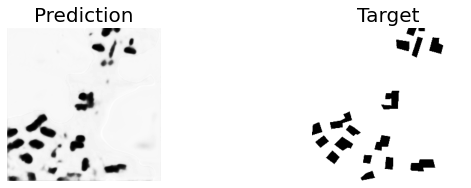

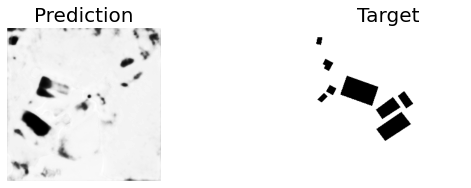

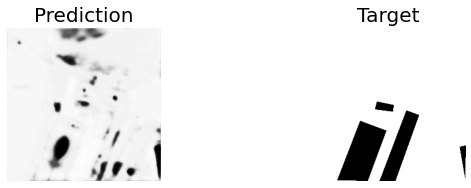

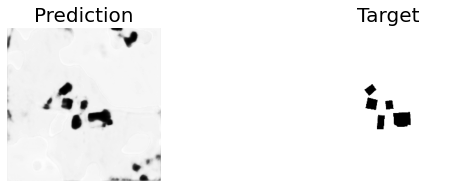

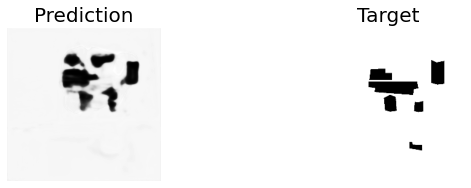

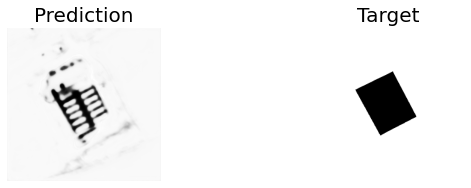

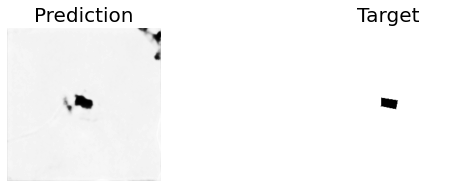

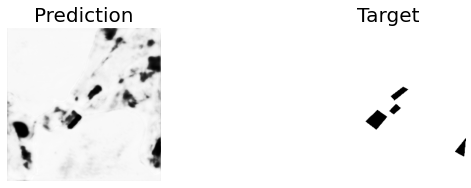

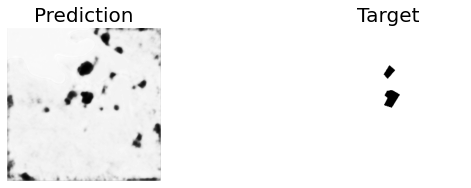

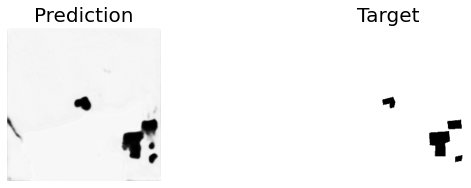

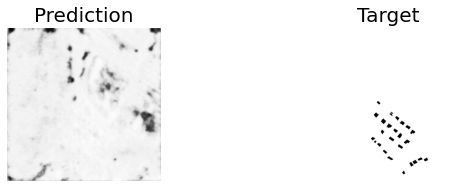

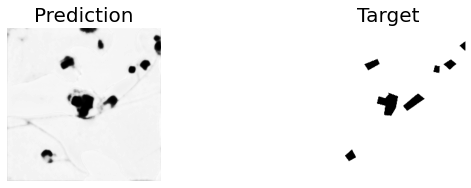

In [31]:
def validate():
    num_examples = val_x.shape[0]
    val_pred = model(val_x).numpy()
    val_imgs = [val_pred[i] for i in range(num_examples)]

    for pred_img, true_img in zip(val_imgs, val_y):
        #pred_img, true_img = val_imgs[img_no], val_y[img_no]
        plt.figure(figsize=(10, 40))
        plt.subplot(num_examples, 2, 1)
        plt.axis('off')
        plt.title('Prediction', fontsize=20)
        plt.imshow(pred_img, cmap='gray')
        plt.subplot(num_examples, 2, 2)
        plt.axis('off')
        plt.title('Target', fontsize=20)
        plt.imshow(true_img, cmap='gray')
    plt.show()

validate()